In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv("/content/drive/MyDrive/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Transactions.csv")

In [4]:
# Step 1: Data Preparation
def prepare_data():
    # Merge customer and transaction data
    combined = pd.merge(transactions, customers, on='CustomerID', how='left')

    # Feature engineering: Total spend, avg spend, purchase frequency, etc.
    customer_features = combined.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean'],
        'TransactionID': 'count',
        'Region': 'first'
    }).reset_index()
    customer_features.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'PurchaseFrequency', 'Region']

    # Encode Region as one-hot
    customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

    return customer_features

In [5]:
# Step 2: Clustering
def perform_clustering(data, n_clusters=5):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.drop(columns=['CustomerID']))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to the data
    data['Cluster'] = cluster_labels

    # Calculate DB Index
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    print(f"DB Index for {n_clusters} clusters: {db_index}")

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")

    return data, db_index, silhouette_avg, kmeans

In [6]:
# Step 3: Visualize Clusters
def visualize_clusters(data):
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data.drop(columns=['CustomerID', 'Cluster']))

    # Scatterplot of clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data['Cluster'], palette='Set2')
    plt.title('Customer Clusters (PCA-reduced)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

DB Index for 2 clusters: 1.7753161843011356
Silhouette Score: 0.21197869335476524
DB Index for 3 clusters: 1.4506169711725612
Silhouette Score: 0.28548389939558455
DB Index for 4 clusters: 1.1896065659883581
Silhouette Score: 0.32898692627766835
DB Index for 5 clusters: 1.1236219126170808
Silhouette Score: 0.3303172676214734
DB Index for 6 clusters: 1.0370977222475906
Silhouette Score: 0.3345009559438784
DB Index for 7 clusters: 0.9722437671869785
Silhouette Score: 0.36769938175301686
DB Index for 8 clusters: 0.970048162953821
Silhouette Score: 0.36702129117199733
DB Index for 9 clusters: 0.9158118006273865
Silhouette Score: 0.3750912592673202
DB Index for 10 clusters: 0.8928183627160464
Silhouette Score: 0.37814926523416736
Optimal Clusters: 10 (DB Index: 0.8928183627160464)
DB Index for 10 clusters: 0.8928183627160464
Silhouette Score: 0.37814926523416736


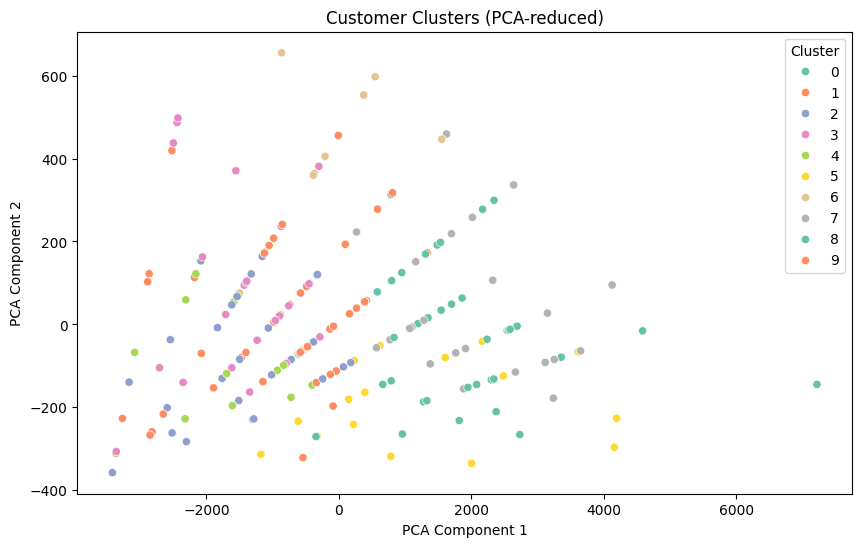

In [7]:
# Main Function
def main():
    # Prepare data
    customer_features = prepare_data()

    # Perform clustering with optimal clusters (2 to 10 clusters)
    results = []
    for n_clusters in range(2, 11):
        clustered_data, db_index, silhouette_avg, kmeans_model = perform_clustering(customer_features.copy(), n_clusters)
        results.append({'n_clusters': n_clusters, 'db_index': db_index, 'silhouette_avg': silhouette_avg})

    # Find the best number of clusters based on DB Index
    best_result = min(results, key=lambda x: x['db_index'])
    print(f"Optimal Clusters: {best_result['n_clusters']} (DB Index: {best_result['db_index']})")

    # Perform final clustering with optimal clusters
    final_data, _, _, _ = perform_clustering(customer_features.copy(), best_result['n_clusters'])

    # Visualize clusters
    visualize_clusters(final_data)

if __name__ == "__main__":
    main()